In [26]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve


In [27]:
# Exercise 1 - Implementation of Naive Bayes Algorithm
# Build a Sentiment Analysis Model for IMDB Movie Review Dataset

# Dataset : IMDB Movie Review is available in shared drive.

# Question:
# You are tasked with building a sentiment analysis model to classify movie reviews as positive or negative
# using the IMDB Movie Review Dataset.
    
# Part 1:
# 1. Load the dataset and preprocess the reviews.
# a. Convert all text to lowercase.
# b. Remove non-alphabetic characters (punctuation).
# c. Tokenize the reviews and remove common stopwords.
# d. Apply stemming to reduce words to their root form.

# 2. Split the dataset into training and testing sets (80% training, 20% testing).

# 3. Use a Naive Bayes classifier to classify the reviews into positive and negative categories.
# a. Implement a Bag-of-Words model using CountVectorizer.
# b. Train the Naive Bayes classifier using the training set.



# Part 1: Load dataset
df = pd.read_csv('IMDB_Dataset.csv')

# Preview dataset
print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [28]:
# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Remove extra spaces
    text = re.sub('\\s+', ' ', text).strip()
    return text

# Apply preprocessing
df['clean_review'] = df['review'].apply(preprocess_text)

In [29]:
# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'], df['sentiment'], test_size=0.2, random_state=42
)

# Bag-of-Words using CountVectorizer with English stopwords
vectorizer = CountVectorizer(stop_words='english')
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vect, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test_vect)
y_pred_prob = nb_classifier.predict_proba(X_test_vect)[:, 1]  # probability for positive class


In [30]:
# Part 2:
# 1. Evaluate the performance of the model using the following metrics:
# a. Accuracy
# b. Precision, Recall, and F1-score
# c. Confusion Matrix
# d. ROC-AUC Score


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8569


In [31]:
# Precision, Recall, F1-score
precision = precision_score(y_test, y_pred, pos_label='positive')
recall = recall_score(y_test, y_pred, pos_label='positive')
f1 = f1_score(y_test, y_pred, pos_label='positive')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Precision: 0.8735
Recall: 0.8373
F1-score: 0.8550


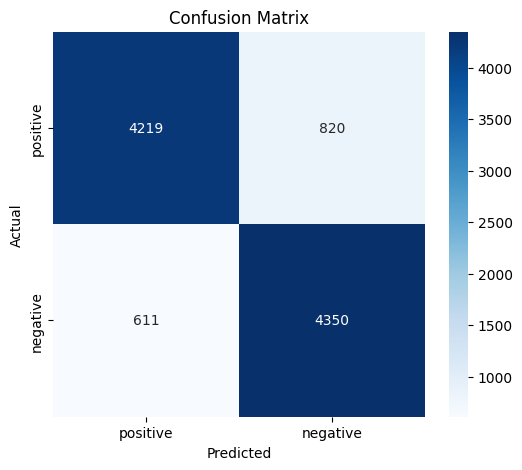

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative'])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [33]:
# ROC-AUC Score
# Convert labels to binary
y_test_binary = y_test.map({'positive': 1, 'negative': 0})
roc_auc = roc_auc_score(y_test_binary, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9250


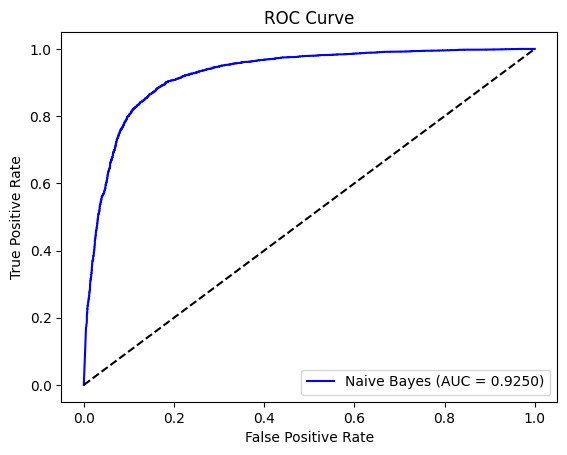

In [34]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [35]:
# Feature Selection Exercise.
# 3.1 Feature Selection using Wrapper Methods.
    
# Dataset: Breast Cancer Prognostic Dataset

# Objective
# You are tasked with identifying the most important features in predicting breast cancer prognosis using the
# Breast Cancer Prognostic Dataset from the UCI Machine Learning Repository. Apply a wrapper method
# (Recursive Feature Elimination) to select the best features and evaluate your model’s performance.


# Part 1: Data Loading and Preprocessing
# 1. Load the Breast Cancer Prognostic Dataset.
    
# 2. Dataset is available in Drive.
    
# 3. Perform basic exploratory data analysis (EDA) to understand the dataset:
# • Summarize key statistics for each feature.
# • Check for missing values and handle them appropriately.
    
# 4. Split the dataset into training (80%) and testing (20%) sets.



# Load the dataset (replace with your path)
data_path = "Breast_Cancer_Prognostic.csv"
df = pd.read_csv(data_path)

# Display first few rows
print("First 5 rows of dataset:")
print(df.head())

First 5 rows of dataset:
   Unnamed: 0   pid  age  meno  size  grade  nodes  pgr  er  hormon  rfstime  \
0           1   132   49     0    18      2      2    0   0       0     1838   
1           2  1575   55     1    20      3     16    0   0       0      403   
2           3  1140   56     1    40      3      3    0   0       0     1603   
3           4   769   45     0    25      3      1    0   4       0      177   
4           5   130   65     1    30      2      5    0  36       1     1855   

   status  
0       0  
1       1  
2       0  
3       0  
4       0  


In [36]:
# Summary statistics
print("Dataset Summary:")
print(df.describe())

Dataset Summary:
       Unnamed: 0          pid         age        meno        size  \
count  686.000000   686.000000  686.000000  686.000000  686.000000   
mean   343.500000   966.061224   53.052478    0.577259   29.329446   
std    198.175427   495.506249   10.120739    0.494355   14.296217   
min      1.000000     1.000000   21.000000    0.000000    3.000000   
25%    172.250000   580.750000   46.000000    0.000000   20.000000   
50%    343.500000  1015.500000   53.000000    1.000000   25.000000   
75%    514.750000  1340.500000   61.000000    1.000000   35.000000   
max    686.000000  1819.000000   80.000000    1.000000  120.000000   

            grade       nodes          pgr           er      hormon  \
count  686.000000  686.000000   686.000000   686.000000  686.000000   
mean     2.116618    5.010204   109.995627    96.252187    0.358601   
std      0.582808    5.475483   202.331552   153.083963    0.479940   
min      1.000000    1.000000     0.000000     0.000000    0.000000 

In [37]:
# Check for missing values
print("Missing Values per Column:")
print(df.isnull().sum())

Missing Values per Column:
Unnamed: 0    0
pid           0
age           0
meno          0
size          0
grade         0
nodes         0
pgr           0
er            0
hormon        0
rfstime       0
status        0
dtype: int64


In [38]:
# Drop non-informative columns
df.drop(['Unnamed: 0', 'pid'], axis=1, inplace=True)

# Fill missing values with mean (numeric only)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Separate features and target
X = df.drop('status', axis=1)
y = df['status']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [39]:
# Part 2: Apply a Wrapper Method
# 1. Use Recursive Feature Elimination (RFE) with a Logistic Regression model to perform feature selection:
# • Select the top 5 features that contribute the most to predicting the target variable.
# • Visualize the ranking of features.

# 2. Train the Logistic Regression model using only the selected features.



# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# RFE to select top 5 features
rfe = RFE(estimator=log_reg, n_features_to_select=5)
rfe.fit(X_train, y_train)

# Selected features
selected_features = X.columns[rfe.support_]
print("Top 5 Selected Features:")
print(selected_features)

Top 5 Selected Features:
Index(['age', 'meno', 'nodes', 'pgr', 'rfstime'], dtype='object')


In [40]:
# Feature ranking
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')
print("Feature Rankings:")
print(feature_ranking)

Feature Rankings:
   Feature  Ranking
0      age        1
1     meno        1
4    nodes        1
5      pgr        1
8  rfstime        1
2     size        2
7   hormon        3
3    grade        4
6       er        5


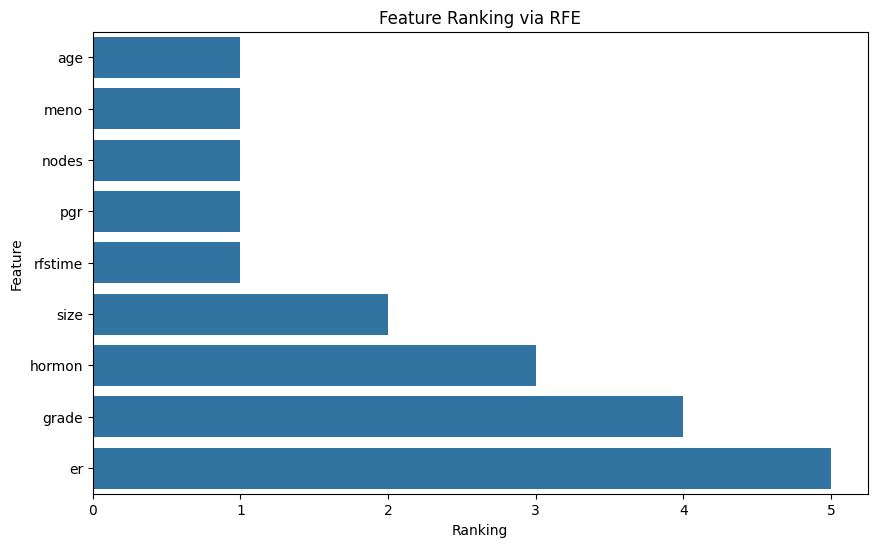

In [41]:
# Visualize feature ranking
plt.figure(figsize=(10,6))
sns.barplot(x='Ranking', y='Feature', data=feature_ranking)
plt.title("Feature Ranking via RFE")
plt.show()


In [42]:
# Train Logistic Regression with selected features
X_train_rfe = X_train[:, rfe.support_]
X_test_rfe = X_test[:, rfe.support_]
log_reg.fit(X_train_rfe, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [43]:
# Part 3: Model Evaluation
# 1. Evaluate the model’s performance using the testing set:
# • Metrics to calculate: Accuracy, Precision, Recall, F1-Score, and ROC-AUC.
    
# 2. Compare the performance of the model trained on all features versus the model trained on the selected features.



y_pred = log_reg.predict(X_test_rfe)
y_prob = log_reg.predict_proba(X_test_rfe)[:,1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob)

print("Model Performance with Top 5 Features:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Model Performance with Top 5 Features:
Accuracy: 0.7029
Precision: 0.7636
Recall: 0.6000
F1-Score: 0.6720
ROC-AUC: 0.7916


In [44]:
# Compare with model using all features
log_reg.fit(X_train, y_train)
y_pred_all = log_reg.predict(X_test)
y_prob_all = log_reg.predict_proba(X_test)[:,1]
accuracy_all = accuracy_score(y_test, y_pred_all)
roc_auc_all = roc_auc_score(y_test, y_prob_all)
print("Model Performance with All Features:")
print(f"Accuracy: {accuracy_all:.4f}")
print(f"ROC-AUC: {roc_auc_all:.4f}")

Model Performance with All Features:
Accuracy: 0.7029
ROC-AUC: 0.7929


In [45]:
# Part 4: Experiment
# 1. Experiment with different numbers of selected features (e.g., top 3, top 7).
    
# 2. Discuss how feature selection affects model performance.



for n in [3, 7]:
    rfe_exp = RFE(estimator=log_reg, n_features_to_select=n)
    rfe_exp.fit(X_train, y_train)
    X_train_exp = X_train[:, rfe_exp.support_]
    X_test_exp = X_test[:, rfe_exp.support_]
    log_reg.fit(X_train_exp, y_train)
    y_pred_exp = log_reg.predict(X_test_exp)
    accuracy_exp = accuracy_score(y_test, y_pred_exp)
    print(f"Model Performance with Top {n} Features:")
    print(f"Accuracy: {accuracy_exp:.4f}")


Model Performance with Top 3 Features:
Accuracy: 0.7319
Model Performance with Top 7 Features:
Accuracy: 0.7101


In [46]:
# Discussion
print("Observation: Selecting top features can simplify the model and reduce overfitting, "
      "but removing too many features may reduce performance. Experimenting with feature count "
      "helps identify the best trade-off between simplicity and accuracy.")

Observation: Selecting top features can simplify the model and reduce overfitting, but removing too many features may reduce performance. Experimenting with feature count helps identify the best trade-off between simplicity and accuracy.
